In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random seed for reproducibility
np.random.seed(42)

# Simulating the true logistic map to generate the bifurcation diagram
r_vals = np.linspace(2.5, 4.5, 401)  # parameter range (extended)
true_r = []
true_x = []
for r in r_vals:
    x = 0.5
    # Discard transients
    for _ in range(100):
        x = r * x * (1 - x)
    # Record subsequent values for bifurcation plot
    for _ in range(100):
        x = r * x * (1 - x)
        true_r.append(r)
        true_x.append(x)
true_r = np.array(true_r)
true_x = np.array(true_x)
# Filter out invalid values (for r>4, the logistic map overflows)
mask = np.isfinite(true_x)
true_r = true_r[mask]
true_x = true_x[mask]


/tmp/ipykernel_58896/2246509255.py:15: RuntimeWarning: overflow encountered in scalar multiply
  x = r * x * (1 - x)


In [15]:
# Defining and training the Echo State Network (ESN)
n_res = 200            # Reservoir size
input_dim = 2          # [x, r] as inputs
output_dim = 1         # predict next x

# Construct a sparse reservoir with specified spectral radius
sparsity = 0.1
W_res = np.random.rand(n_res, n_res) - 0.5
mask = (np.random.rand(n_res, n_res) < sparsity)
W_res *= mask
# Scale to desired spectral radius
eigvals = np.linalg.eigvals(W_res)
W_res *= (0.95 / np.max(np.abs(eigvals)))

# Input weight matrix (random)
W_in = (np.random.rand(n_res, input_dim) - 0.5) * 1.0

# Prepare training data from logistic map with r in [3.4, 3.8]
r_train_vals = np.linspace(3.4, 3.8, 21)
T_skip = 100
T_train = 500

states_list = []
x_in_list = []
r_in_list = []
x_out_list = []

for r in r_train_vals:
    x = np.random.rand()
    s = np.zeros(n_res)
    # Skip initial transients (teacher-forced update)
    for _ in range(T_skip):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        x = r * x * (1 - x)
    # Collect reservoir states and targets
    for _ in range(T_train):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        states_list.append(s.copy())
        x_in_list.append(x)
        r_in_list.append(r)
        x_next = r * x * (1 - x)
        x_out_list.append(x_next)
        x = x_next

states_train = np.array(states_list).T  # shape (n_res, N_total)
x_in_train = np.array(x_in_list)
r_in_train = np.array(r_in_list)
y_train = np.array(x_out_list)

# Build design matrix [reservoir_states; x; r; 1]
ones = np.ones_like(x_in_train)
X_design = np.vstack([states_train,
                      x_in_train.reshape(1,-1),
                      r_in_train.reshape(1,-1),
                      ones.reshape(1,-1)])

# Train output weights via ridge regression
reg = 1e-8
XTX = X_design.dot(X_design.T)
Id = np.eye(X_design.shape[0])
W_out = (y_train.reshape(1,-1).dot(X_design.T)).dot(np.linalg.inv(XTX + reg * Id))


In [ ]:
# Using the trained ESN to reconstruct (predict) bifurcation over extended range
r_pred_vals = np.linspace(2.5, 4.5, 201)
T_skip_pred = 100
T_gen = 500

pred_r = []
pred_x = []

for r in r_pred_vals:
    x = np.random.rand()
    s = np.zeros(n_res)
    # Skip to warm up ESN (if r <= 4, use true logistic; if r > 4, use ESN prediction to avoid overflow)
    if r <= 4.0:
        for _ in range(T_skip_pred):
            u = np.array([x, r])
            s = np.tanh(W_res.dot(s) + W_in.dot(u))
            x = r * x * (1 - x)
    else:
        for _ in range(T_skip_pred):
            u = np.array([x, r])
            s = np.tanh(W_res.dot(s) + W_in.dot(u))
            ext = np.concatenate((s, [x, r, 1.0]))
            x = float(W_out.dot(ext))
    # Generate predictions (free-run)
    for _ in range(T_gen):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        ext = np.concatenate((s, [x, r, 1.0]))
        x = float(W_out.dot(ext))
        pred_r.append(r)
        pred_x.append(x)

pred_r = np.array(pred_r)
pred_x = np.array(pred_x)
# Filter out non-finite predictions
mask_pred = np.isfinite(pred_x)
pred_r = pred_r[mask_pred]
pred_x = pred_x[mask_pred]


/tmp/ipykernel_58896/794453763.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(W_out.dot(ext))
/tmp/ipykernel_58896/794453763.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(W_out.dot(ext))


In [17]:
# Generating return-plot data for representative cases r=3.5 (periodic) and r=3.8 (chaotic)
r_periodic = 3.5
r_chaotic = 3.8
x0 = 0.2
trans = 100
series_len = 5000

# True logistic series (after transients)
def logistic_series(r, x0, skip, length):
    x = x0
    for _ in range(skip):
        x = r * x * (1 - x)
    series = [x]
    for _ in range(length):
        x = r * x * (1 - x)
        series.append(x)
    return np.array(series)

series_true_periodic = logistic_series(r_periodic, x0, trans, series_len)
series_true_chaotic  = logistic_series(r_chaotic,  x0, trans, series_len)

# ESN-predicted series (using the trained network)
def esn_series(r, x0, skip, length):
    x = x0
    s = np.zeros(n_res)
    # Warm-up with true logistic to initialize x
    for _ in range(skip):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        x = r * x * (1 - x)
    series = []
    for _ in range(length):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        ext = np.concatenate((s, [x, r, 1.0]))
        x = float(W_out.dot(ext))
        series.append(x)
    return np.array(series)

series_esn_periodic = esn_series(r_periodic, x0, trans, series_len)
series_esn_chaotic  = esn_series(r_chaotic,  x0, trans, series_len)


/tmp/ipykernel_58896/2276887318.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(W_out.dot(ext))


In [ ]:
# Computing approximate Lyapunov exponents for true vs. ESN trajectories
r_lya_vals = np.linspace(2.5, 4.0, 51)
lyap_true = []
lyap_esn = []

for r in r_lya_vals:
    # True logistic Lyapunov
    x = 0.5
    for _ in range(100):
        x = r * x * (1 - x)
    vals = []
    for _ in range(500):
        vals.append(np.log(abs(r * (1 - 2*x))))
        x = r * x * (1 - x)
    lyap_true.append(np.mean(vals))
    # ESN series Lyapunov (skip as above)
    x = 0.5
    s = np.zeros(n_res)
    for _ in range(100):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        x = r * x * (1 - x)
    vals2 = []
    for _ in range(500):
        u = np.array([x, r])
        s = np.tanh(W_res.dot(s) + W_in.dot(u))
        ext = np.concatenate((s, [x, r, 1.0]))
        x = float(W_out.dot(ext))
        vals2.append(np.log(abs(r * (1 - 2*x))))
    lyap_esn.append(np.mean(vals2))

lyap_true = np.array(lyap_true)
lyap_esn  = np.array(lyap_esn)
# Filter out any non-finite values (if any divergence)
finite_mask = np.isfinite(lyap_esn)
r_lya_vals = r_lya_vals[finite_mask]
lyap_true = lyap_true[finite_mask]
lyap_esn  = lyap_esn[finite_mask]


/tmp/ipykernel_58896/4276299988.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(W_out.dot(ext))


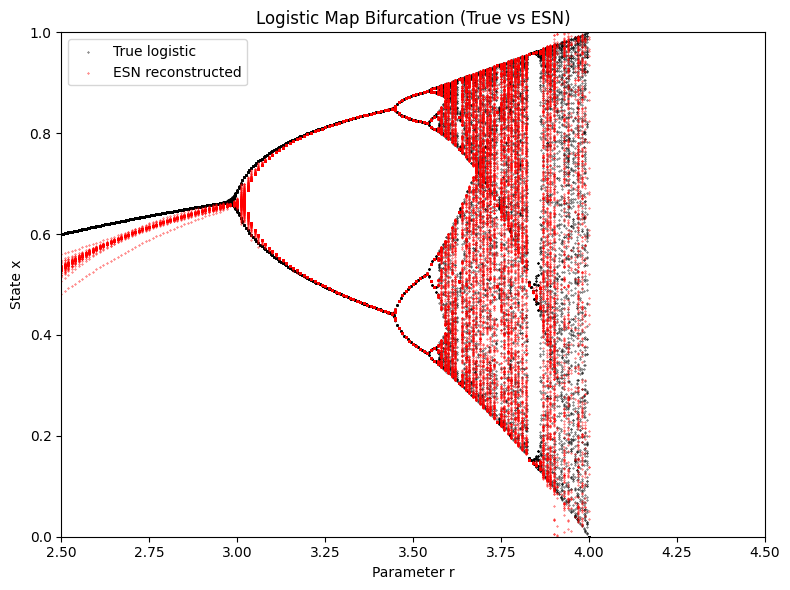

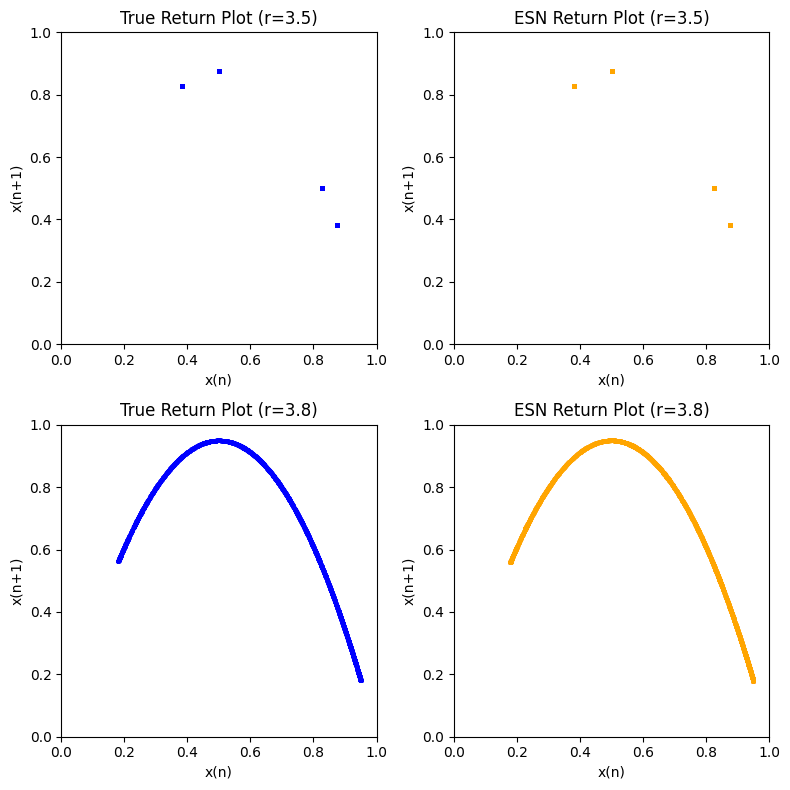

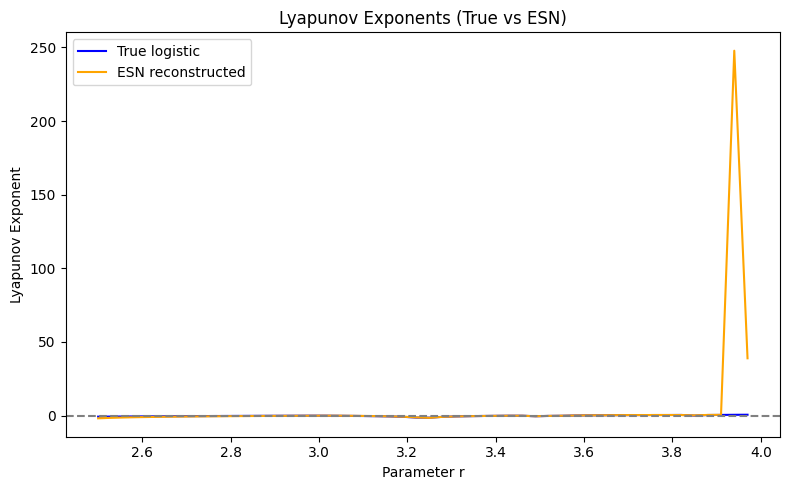

In [ ]:
# Plotting

# Bifurcation diagram (true vs. ESN)
plt.figure(figsize=(8,6))
plt.scatter(true_r, true_x, s=0.1, color='black', label='True logistic')
plt.scatter(pred_r, pred_x, s=0.1, color='red', label='ESN reconstructed')
plt.xlim(2.5, 4.5)
plt.ylim(0, 1)
plt.xlabel('Parameter r')
plt.ylabel('State x')
plt.title('Logistic Map Bifurcation (True vs ESN)')
plt.legend()
plt.tight_layout()
plt.show()

# Return plots: (x_t vs x_{t+1}) for periodic and chaotic cases
fig, axes = plt.subplots(2, 2, figsize=(8,8))
# True periodic (r=3.5)
axes[0,0].scatter(series_true_periodic[:-1], series_true_periodic[1:], s=5, color='blue', alpha=0.5)
axes[0,0].set_title(f'True Return Plot (r={r_periodic})')
axes[0,0].set_xlabel('x(n)')
axes[0,0].set_ylabel('x(n+1)')
axes[0,0].set_xlim(0,1); axes[0,0].set_ylim(0,1)
# ESN periodic
axes[0,1].scatter(series_esn_periodic[:-1], series_esn_periodic[1:], s=5, color='orange', alpha=0.5)
axes[0,1].set_title(f'ESN Return Plot (r={r_periodic})')
axes[0,1].set_xlabel('x(n)')
axes[0,1].set_ylabel('x(n+1)')
axes[0,1].set_xlim(0,1); axes[0,1].set_ylim(0,1)
# True chaotic (r=3.8)
axes[1,0].scatter(series_true_chaotic[:-1], series_true_chaotic[1:], s=5, color='blue', alpha=0.5)
axes[1,0].set_title(f'True Return Plot (r={r_chaotic})')
axes[1,0].set_xlabel('x(n)')
axes[1,0].set_ylabel('x(n+1)')
axes[1,0].set_xlim(0,1); axes[1,0].set_ylim(0,1)
# ESN chaotic
axes[1,1].scatter(series_esn_chaotic[:-1], series_esn_chaotic[1:], s=5, color='orange', alpha=0.5)
axes[1,1].set_title(f'ESN Return Plot (r={r_chaotic})')
axes[1,1].set_xlabel('x(n)')
axes[1,1].set_ylabel('x(n+1)')
axes[1,1].set_xlim(0,1); axes[1,1].set_ylim(0,1)
plt.tight_layout()
plt.show()

# Lyapunov exponents comparison
plt.figure(figsize=(8,5))
plt.plot(r_lya_vals, lyap_true, label='True logistic', color='blue')
plt.plot(r_lya_vals, lyap_esn,  label='ESN reconstructed', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Parameter r')
plt.ylabel('Lyapunov Exponent')
plt.title('Lyapunov Exponents (True vs ESN)')
plt.legend()
plt.tight_layout()
plt.show()
